In [11]:
import hyppo
from hyppo.discrim._utils import _CheckInputs
from hyppo.independence import Dcorr
from dask.distributed import Client, progress
import dask.dataframe as ddf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA

# Simulation Dependencies

In [12]:
from onesample import *
from simhelper import *
from onesample_sims import *

# No Effect

In [13]:
X, y, z = noeff_onesample(50, 2, 2, 2)

w, b, ratio = statistic(X, y, z)
dcor = dcorr_statistic(X, z)
manova = manova_statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))
print("Dcor: {:3f}".format(dcor))
print("Manova: {:3f}".format(manova))

Within: 0.819601
Between: 0.814750
Ratio: 0.994081
Dcor: 0.011498
Manova: 0.985006


In [ ]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

# Effect

In [6]:
X, y, z = gaussian_onesample(50, 2, 2, 2, effect_size=1)

w, b, ratio = statistic(X, y, z)
dcor = dcorr_statistic(X, z)
manova = manova_statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))
print("Dcor: {:3f}".format(dcor))
print("Manova: {:3f}".format(manova))

Within: 0.828749
Between: 0.872687
Ratio: 1.053017
Dcor: 0.232158
Manova: 0.587143


In [ ]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

# Circle

In [7]:
X, y, z = ballcirc_onesample(50, 2, 2, 2)

w, b, ratio = statistic(X, y, z)
dcor = dcorr_statistic(X, z)
manova = manova_statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))
print("Dcor: {:3f}".format(dcor))
print("Manova: {:3f}".format(manova))

Within: 0.900852
Between: 0.989423
Ratio: 1.098320
Dcor: 0.207217
Manova: 0.977632


<AxesSubplot:xlabel='x1', ylabel='x2'>

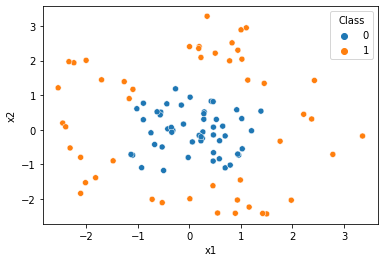

In [8]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

## One sample test

\begin{align*}
    H_0 : r = r_c\text{ against }H_A: r > r_c
\end{align*}
Where $r_c$ is the ratio $\frac{b_c}{w_c}$ if the class difference were $0$; that is, $\beta = 0_d$.

In [ ]:
ncores = 70
client = Client(threads_per_worker=1, n_workers=ncores)
client

In [ ]:
outer_reps = 100
pvalues = []
Nsubs = []
Nbreaks = 6
T = 3
ndim = 2
reps = 1000

def run_exp_ost(row):
    if row[0] == "Gaussian":
        X, y, z = gaussian_onesample(int(row[1]), T, ndim, 2)
    if row[0] == "No Effect":
        X, y, z = noeff_onesample(int(row[1]), T, ndim, 2)
    if row[0] == "Circle/Disc":
        X, y, z = ballcirc_onesample(int(row[1]), T, ndim, 2)
    _, pvalue_cdiscr, _ = one_sample_test(X, y, z, reps=reps)
    pvalue_manova = one_sample_manova(X, y, z)
    _, pvalue_dcorr = one_sample_dcorr(X, z, reps=reps)
    return (row[0], row[1], row[2], pvalue_cdiscr, pvalue_manova, pvalue_dcorr)

exps = []
for exp_type in ["No Effect", "Gaussian", "Circle/Disc"]:
    for Nsub in np.floor(2**np.linspace(4, 7, num=Nbreaks)):
        for i in range(outer_reps):
            exps.append([exp_type, int(Nsub), i])

sim_exps = pd.DataFrame(exps, columns=["Simulation", "NSubs", "ID"])
print(sim_exps.head())
print(sim_exps.shape)

In [ ]:
sim_exps = ddf.from_pandas(sim_exps, npartitions=int(ncores*1.5))
sim_results = sim_exps.apply(lambda x: run_exp_ost(x), axis=1, result_type="expand",
                            meta={0: object, 1: int, 2: int, 3: float, 4: float, 5: float})
sim_results

In [ ]:
sim_results = sim_results.compute(scheduler="multiprocessing")
sim_results = sim_results.rename(columns={0: "Simulation", 1: "NSubs", 2: "index", 3: "pvalue_cdiscr",
                                          4: "pvalue_manova", 5: "pvalue_dcorr"})
sim_results.to_csv('./data/sims_onesample.csv')

In [ ]:
sim_results = pd.read_csv('./data/sims_onesample.csv')
long_results = pd.wide_to_long(sim_results, stubnames="pvalue", i=["Simulation", "NSubs", "index"],
                               j="Statistic", sep="_", suffix='\\w+')

In [ ]:
alpha = .05
long_results["Outcome"] = long_results["pvalue"] < alpha
long_results_power = long_results.groupby(["Simulation", "NSubs", "Statistic"]).agg({"Outcome": np.mean}).reset_index()

In [ ]:
long_results_power

In [ ]:
g = sns.FacetGrid(long_results_power, col="Simulation", hue="Statistic")
g.map(sns.lineplot, "NSubs", "Outcome")
g.add_legend();

# Asymptotic Consistency of $w$ and $b$

In [ ]:
outer_reps = 200
ws = []
bs = []
Nsubs = []
for Nsub in np.floor(2**np.linspace(4, 8, num=10)):
    print(int(Nsub))
    for i in range(outer_reps):
        X, y, z = simulate_gaussian_eff(int(Nsub), 2, 2, 2)
        w, b, ratio = statistic(X, y, z)
        ws.append(w)
        bs.append(b)
        Nsubs.append(Nsub)

In [ ]:
data = pd.DataFrame({"Within": ws, "Between": bs, "Number": Nsubs})
data["B/W"] = data["Between"]/data["Within"]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=data, x="Number", y="Within", ax=axs[0], ci="sd")
sns.lineplot(data=data, x="Number", y="Between", ax=axs[1], ci="sd")
sns.lineplot(data=data, x="Number", y="B/W", ax=axs[2], ci="sd")
axs[0].set_ylabel("Within Subject Discr")
axs[1].set_ylabel("Between Subject Discr")
axs[2].set_ylabel("B/W Ratio")
axs[0].set_xlabel("N")
axs[1].set_xlabel("N")
axs[2].set_xlabel("N")